# Steps

1. ## Import SVHN dataset
2. ## Data preprocessing
   - Check data type
   - Convert to float for image and to int for label
   - Normalize the data
   - One-hot encoding for labels
   - Data augmentation
      > augment the images in the dataset, by randomly rotating them, zooming them in and out, shifting them up and down
 
 <br>
 
 3. ## Create CNN model

 4. ## Train & Test

 5. ## Results and discussion


In [1]:
# load dataset
import h5py

# data is loaded from local path, please update local_path according to your own dataset location
local_path = "C:/Users/kaili/OneDrive/Desktop/CS6140 ML/Project Dataset/"

# load digitStruct.mat
data_path = local_path + "train/digitStruct.mat"
f = h5py.File(data_path, 'r')

def printname(name):
    print(name)

# get names of h5py groups within digitStruct
f['digitStruct'].visit(printname) # digitStruct.mat contains information of bbox, name of the images
# ref: https://docs.h5py.org/en/stable/quick.html

bbox
name


In [2]:
# get dataset for each group
digitStructName = f['digitStruct']['name']
digitStructBbox = f['digitStruct']['bbox']

# get bbox for each instance. bbox is a library describing the bounder box position
def get_bbox(n):
    bbox = {}
    bb = digitStructBbox[n].item()
    def bbox_helper(attr_type):
        attr = f[bb][attr_type]
        if len(attr) > 1:
            pos = [int(f[attr[j].item()][0][0]) for j in range(len(attr))]
        else:
            pos = [attr[0][0]]

        return pos
    bbox['label'] = bbox_helper('label')
    bbox['height'] = bbox_helper('height')
    bbox['left'] = bbox_helper('left')
    bbox['top'] = bbox_helper('top')
    bbox['width'] = bbox_helper('width')
    return bbox

# get file name for each instance. File names are indexes starting from 1
def get_name(n):
    name = ''.join([chr(v[0]) for v in f[(digitStructName[n][0])]])
    return name

{'label': [1, 2, 10], 'height': [37, 37, 37], 'left': [50, 66, 85], 'top': [7, 7, 11], 'width': [15, 21, 27]}
98.png


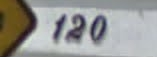

In [3]:
# test using first image
print(get_bbox(97))
print(get_name(97))
from IPython.display import Image
img_path_test = local_path + "/train/98.png"
Image(filename=img_path_test)

In [4]:
# store bbox and file name into dict
# image_dict = {}
# for i in range(len(digitStructName)):
#     file_name = get_name(i)
#     image_dict[file_name] = get_bbox(i)

In [5]:
import torchvision
import torchvision.transforms as transforms
import cv2
import os

# test using first image
#digit_dict = image_dict['1.png']
digit_dict = get_bbox(0)
image_name = get_name(0)
img_path_crop_test = local_path + 'train/' + image_name
image = cv2.imread(img_path_crop_test)
n_drop = 0

# for each label, crop the image
for label_index in range(len(digit_dict['label'])):
    label = int(digit_dict['label'][label_index])
    # label 0 is represented using 10
    if label == 10:
        label = 0

    # get crop position
    left = int(digit_dict['left'][label_index])
    upper = int(digit_dict['top'][label_index])
    right = int(left + digit_dict['width'][label_index])
    lower = int(upper + digit_dict['height'][label_index])

    # invalid data
    if left < 0 or upper < 0:
        n_drop += 1
        continue

    # crop image
    img = image[upper:lower, left:right, :]

    # transpose image into size 32 * 32 grayscale tensor format
    transformed_img = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.Grayscale(1),
             transforms.Resize((32, 32)),
             transforms.ToTensor()])(img)
    # ref: http://man.hubwiz.com/docset/torchvision.docset/Contents/Resources/Documents/transforms.html

    process_folder = local_path + 'process/'
    # check whether the process folder exists or not
    if not os.path.exists(process_folder):
        # create a new directory because it does not exist
        os.makedirs(process_folder)
        print("Created the process folder to store preprocessed images")

    # store image as original file name + _ + label + _ + label index, saved in process folder
    save_file_path = '_'.join([process_folder + image_name.split('.')[0], str(label_index), str(label) +'.png'])

    # save cropped image
    torchvision.utils.save_image(transformed_img, save_file_path)

### PLEASE RUN FROM HERE

In [6]:
import h5py
import torchvision
import torchvision.transforms as transforms
import cv2
import os
from IPython.display import Image


In [7]:
# following class are used for image crop and get cropped image path 
class CropImage(object):
    def __init__ (self, local_path, mode):
        # load digitStruct.mat
        self.local_path = local_path
        self.mode = mode
        if mode == "train":
            self.f = h5py.File(local_path + "/train/digitStruct.mat", 'r')
        elif mode == "test":
            self.f = h5py.File(local_path + "/test/digitStruct.mat", 'r')
        # get dataset for each group
        self.digitStructName = self.f['digitStruct']['name']
        self.digitStructBbox = self.f['digitStruct']['bbox']
        self.file_path_dict = {}
        
    # get bbox for each instance. bbox is a library describing the bounder box position
    def get_bbox(self, n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        def bbox_helper(attr_type):
            attr = self.f[bb][attr_type]
            if len(attr) > 1:
                pos = [int(self.f[attr[j].item()][0][0]) for j in range(len(attr))]
            else:
                pos = [attr[0][0]]

            return pos
        bbox['label'] = bbox_helper('label')
        bbox['height'] = bbox_helper('height')
        bbox['left'] = bbox_helper('left')
        bbox['top'] = bbox_helper('top')
        bbox['width'] = bbox_helper('width')
        return bbox

    # get file name for each instance. File names are indexes starting from 1
    def get_name(self, n):
        name = ''.join([chr(v[0]) for v in self.f[(self.digitStructName[n][0])]])
        return name

    def save_path_to_dict(self, original_file_name, save_file_path, img):
        # save path to dict
        if original_file_name not in self.file_path_dict:
            self.file_path_dict[original_file_name] = [save_file_path]
        elif save_file_path not in self.file_path_dict[original_file_name]:
            self.file_path_dict[original_file_name].append(save_file_path)
        # save cropped image
        torchvision.utils.save_image(img, save_file_path)

    # crop image for each instance, also save cropped image name to the dict
    def crop_image(self, n):
        n_drop = 0
        # for each label, crop the image
        digit_dict = self.get_bbox(n)
        
        for label_index in range(len(digit_dict['label'])):
            label = int(digit_dict['label'][label_index])
            # label 0 is represented using 10
            if label == 10:
                label = 0

            # get crop position
            left = int(digit_dict['left'][label_index])
            upper = int(digit_dict['top'][label_index])
            right = int(left + digit_dict['width'][label_index])
            lower = int(upper + digit_dict['height'][label_index])

            # invalid data
            if left < 0 or upper < 0:
                n_drop += 1
                continue

            # crop image
            img_path_crop_test = self.local_path + '/train/' + self.get_name(n)
            image = cv2.imread(img_path_crop_test)
            img = image[upper:lower, left:right, :]

            # transpose image into size 32 * 32 grayscale tensor format
            transformed_img = transforms.Compose(
                    [transforms.ToPILImage(),
                     transforms.Grayscale(1),
                     transforms.Resize((32, 32)),
                     transforms.ToTensor()])(img)
            # ref: http://man.hubwiz.com/docset/torchvision.docset/Contents/Resources/Documents/transforms.html

            process_folder = self.local_path + '/process/'
            # check whether the process folder exists or not
            if not os.path.exists(process_folder):
                # create a new directory because it does not exist
                os.makedirs(process_folder)
                print("Created the process folder to store preprocessed images")

            # store image as original file name + _ + label + _ + label index, saved in process folder
            original_file_name = self.get_name(n).split('.')[0]

            file_head = '_'.join([process_folder + original_file_name, str(label_index), str(label)])
            file_tail = '.png'
            inverted_file_tail = '_iv.png'

            # invert grayscale image to get a new image, by doing so we could expande our training data set
            if self.mode == "train":
                inverted_transformed_img = transforms.functional.invert(transformed_img)
                self.save_path_to_dict(original_file_name, file_head+inverted_file_tail, inverted_transformed_img)
        
            self.save_path_to_dict(original_file_name, file_head+file_tail, transformed_img)
    
    # get a list of cropped image file path
    def get_cropped_image_path(self, n):
        curr_path = self.local_path + "/train" if self.mode == "train" else self.local_path + "/test"
        # check the file name is out of range, max is 33401 for train, 13065 for test
        if n + 1 not in self.file_path_dict:
            if n + 3 >= len(os.listdir(curr_path)):
                print("Please check the file name!", n) ### changed
            else:
                # havent been processed yet
                self.crop_image(n)
        # return a list of file path name of the cropped file 
        return self.file_path_dict[str(n+1)]


In [8]:
# test functionality
# replace "local_path" to your real local path before test, e.g. "/Users/evelynhsu/CS6140"
'''
ci_train = CropImage(local_path="../dataset", mode="train")
ci_train.get_cropped_image_path(78)

ci_test = CropImage(local_path="../dataset", mode="test")
ci_test.get_cropped_image_path(3)
'''

'\nci_train = CropImage(local_path="../dataset", mode="train")\nci_train.get_cropped_image_path(78)\n\nci_test = CropImage(local_path="../dataset", mode="test")\nci_test.get_cropped_image_path(3)\n'

# Update

In [9]:
import os
import numpy as np
import glob

In [12]:

def create_input(local_path, mode):
    X, y = [], []
    data = CropImage(local_path, mode)

    dataset_path = local_path + "/" + mode
    total_image_num = len(glob.glob1(dataset_path,"*.png"))
    print("Total image num: ", total_image_num)

    for idx in range(total_image_num): #####
        image_filename = idx + 1

        try:
            cropped_img_dir_list = data.get_cropped_image_path(image_filename)

            if len(cropped_img_dir_list) != len(data.get_bbox(image_filename)['label'] * 2):
                print("1. Skipped, Number of cropped image is inconsistent with labels, img number:", image_filename, data.get_bbox(image_filename)['label'])
                continue

            for cropped_img_dir in cropped_img_dir_list:
                cropped_img = cv2.imread(cropped_img_dir)
                X.append(cropped_img)

            for l in data.get_bbox(image_filename)['label']:
                if l == 10:
                    y += [0] * 2
                else:
                    y += [l] * 2

        except:
            print("2. Skipped, No cropped image output, img number:", image_filename)
            continue
    
    return np.array(X), np.array(y)

In [13]:
# local_path = "C:/Users/kaili/OneDrive/Desktop/CS6140 ML/Project Dataset"
# mode = "train"
# img = 97
# data = CropImage(local_path, mode)
# cropped_img_dir_list = data.get_cropped_image_path(img) 
# print(cropped_img_dir_list)
# print(data.get_bbox(img)['label'])

In [14]:
# Create Train datasets 
# ETA 38min
local_path = "C:/Users/kaili/OneDrive/Desktop/CS6140 ML/Project Dataset"
mode = "train"
X_train, y_train = create_input(local_path, mode)
print(X_train.shape, y_train.shape)

Total image num:  33402
1. Skipped, Number of cropped image is inconsistent with labels, img number: 251 [3, 7, 10]
1. Skipped, Number of cropped image is inconsistent with labels, img number: 723 [2, 7]
2. Skipped, No cropped image output, img number: 1393
1. Skipped, Number of cropped image is inconsistent with labels, img number: 3099 [1, 2, 6]
1. Skipped, Number of cropped image is inconsistent with labels, img number: 5311 [2, 10, 8]
2. Skipped, No cropped image output, img number: 6876
1. Skipped, Number of cropped image is inconsistent with labels, img number: 9356 [8, 2, 5]
2. Skipped, No cropped image output, img number: 11860
2. Skipped, No cropped image output, img number: 13144
1. Skipped, Number of cropped image is inconsistent with labels, img number: 15124 [3, 5]
1. Skipped, Number of cropped image is inconsistent with labels, img number: 18276 [1, 1]
1. Skipped, Number of cropped image is inconsistent with labels, img number: 18392 [3, 1]
1. Skipped, Number of cropped i

In [15]:
'''
local_path = "C:/Users/kaili/OneDrive/Desktop/CS6140 ML/Project Dataset"
mode = "test"
img = 2
data2 = CropImage(local_path, mode)
cropped_img_dir_list = data2.get_cropped_image_path(img) 
print(cropped_img_dir_list)
print(data2.get_bbox(img)['label'])
'''

'\nlocal_path = "C:/Users/kaili/OneDrive/Desktop/CS6140 ML/Project Dataset"\nmode = "test"\nimg = 2\ndata2 = CropImage(local_path, mode)\ncropped_img_dir_list = data2.get_cropped_image_path(img) \nprint(cropped_img_dir_list)\nprint(data2.get_bbox(img)[\'label\'])\n'

In [16]:
# # Create Test datasets
# local_path = "C:/Users/kaili/OneDrive/Desktop/CS6140 ML/Project Dataset"
# mode = "test"
# X_test, y_test = create_input(local_path, mode)
# print(X_test.shape, y_test.shape)

Sequential model from keras

1. CNN Class - modify numbers & order of layers according to information loss?
    e.g. 
    Class CNN():
        def __init__(self, layer_num=None, layer_order=None):
            pass

2. for all training instance:
        for all numbers in instance:
            input to the current CNN model



3. Model evaluation:
    a. confusion matrix:
        0  1  2  3  4 5 6 7 8 9
    0
    1
    2
    ...

    b. Feature Maps - output of each layers

In [18]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [23]:
# Create CNN model
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu')) # w/o 0.35 accuracy 0.8949

cnn_model.add(layers.Flatten()) 
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(10, activation='softmax'))

cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# Fit train data ~11min
cnn_model.fit(X_train, y_train, epochs=10)

Epoch 1/10
4575/4575 [==============================] - 68s 15ms/step - loss: 0.9349 - accuracy: 0.7447
Epoch 2/10
4575/4575 [==============================] - 67s 15ms/step - loss: 0.5635 - accuracy: 0.8367
Epoch 3/10
4575/4575 [==============================] - 67s 15ms/step - loss: 0.5002 - accuracy: 0.8553
Epoch 4/10
4575/4575 [==============================] - 66s 14ms/step - loss: 0.4655 - accuracy: 0.8638
Epoch 5/10
4575/4575 [==============================] - 66s 15ms/step - loss: 0.4378 - accuracy: 0.8709
Epoch 6/10
4575/4575 [==============================] - 67s 15ms/step - loss: 0.4182 - accuracy: 0.8768
Epoch 7/10
4575/4575 [==============================] - 67s 15ms/step - loss: 0.4026 - accuracy: 0.8813
Epoch 8/10
4575/4575 [==============================] - 68s 15ms/step - loss: 0.3886 - accuracy: 0.8857
Epoch 9/10
4575/4575 [==============================] - 65s 14ms/step - loss: 0.3783 - accuracy: 0.8881
Epoch 10/10
4575/4575 [==============================] - 68s 15m

In [26]:
# cnn.evaluate(X_test,y_test)
cnn_model.evaluate(X_train,y_train) # loss: 0.2900 - accuracy: 0.9131
cnn_model.summary()

4575/4575 [==============================] - 24s 5ms/step - loss: 0.3359 - accuracy: 0.9002
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                147520    
____________________________

In [27]:
# cnn_model.evaluate(X_test,y_test) # loss: xxx - accuracy: xxx
# y_pred = cnn_model.predict(X_test)

